<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [15]:
import torchvision

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [16]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

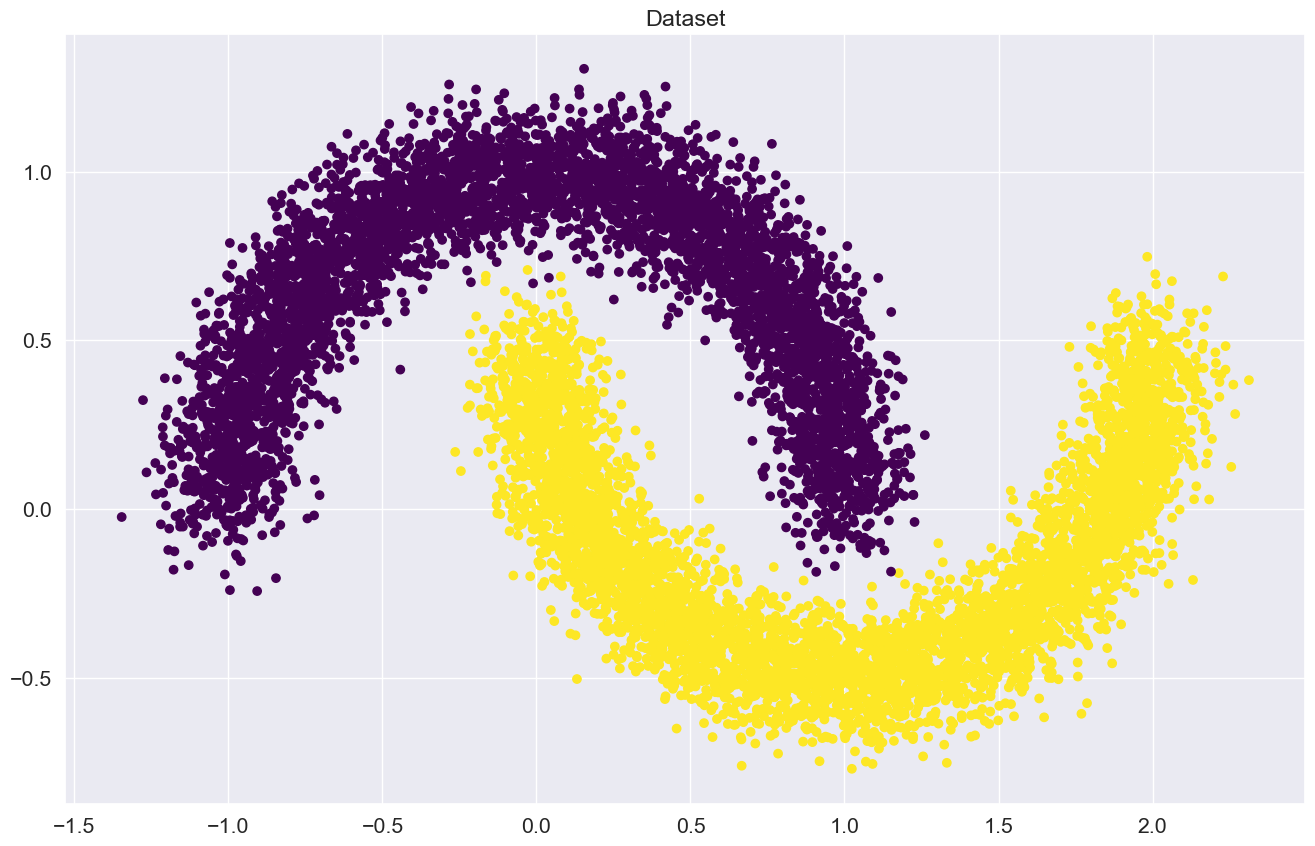

In [17]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [19]:
X_train_t = torch.from_numpy(X_train) # YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train) # YOUR CODE GOES HERE
X_val_t = torch.from_numpy(X_val) # YOUR CODE GOES HERE
y_val_t = torch.from_numpy(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [20]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [21]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)).float()
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1, out_features))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x.float() @ self.weights  # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [22]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

- Ответом на вопрос является число весов (2 штуки) плюс бейс (1 штука) == 3

In [23]:
linear_regression.__annotations__

{'dump_patches': bool,
 '_version': int,
 'training': bool,
 '_parameters': typing.Dict[str, typing.Optional[torch.nn.parameter.Parameter]],
 '_buffers': typing.Dict[str, typing.Optional[torch.Tensor]],
 '_non_persistent_buffers_set': typing.Set[str],
 '_backward_pre_hooks': typing.Dict[int, typing.Callable],
 '_backward_hooks': typing.Dict[int, typing.Callable],
 '_is_full_backward_hook': typing.Optional[bool],
 '_forward_hooks': typing.Dict[int, typing.Callable],
 '_forward_hooks_with_kwargs': typing.Dict[int, bool],
 '_forward_pre_hooks': typing.Dict[int, typing.Callable],
 '_forward_pre_hooks_with_kwargs': typing.Dict[int, bool],
 '_state_dict_hooks': typing.Dict[int, typing.Callable],
 '_load_state_dict_pre_hooks': typing.Dict[int, typing.Callable],
 '_state_dict_pre_hooks': typing.Dict[int, typing.Callable],
 '_load_state_dict_post_hooks': typing.Dict[int, typing.Callable],
 '_modules': typing.Dict[str, typing.Optional[ForwardRef('Module')]],
 'call_super_init': bool,
 'forward':

In [24]:
linear_regression._parameters

OrderedDict([('weights',
              Parameter containing:
              tensor([[-0.1026],
                      [ 0.2758]], requires_grad=True)),
             ('bias_term',
              Parameter containing:
              tensor([[-0.8605]], requires_grad=True))])

In [25]:
from torchinfo import summary

print(summary(linear_regression, (1, 2)))
None

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [26]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch.float())[:,0] # YOUR CODE. Use linear_regression to get outputs
        # print(outp.flatten().shape, y_batch.view(-1, 1).shape)
        loss = loss_function(outp.flatten().float(), y_batch.float()) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.7578125
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.875
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8125
Iteration: 800
Batch accuracy: 0.8359375

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 814 (каждый раз разная поэтому если не то число стоит просто посмотрите наверх 0o0)

### Визуализируем результаты

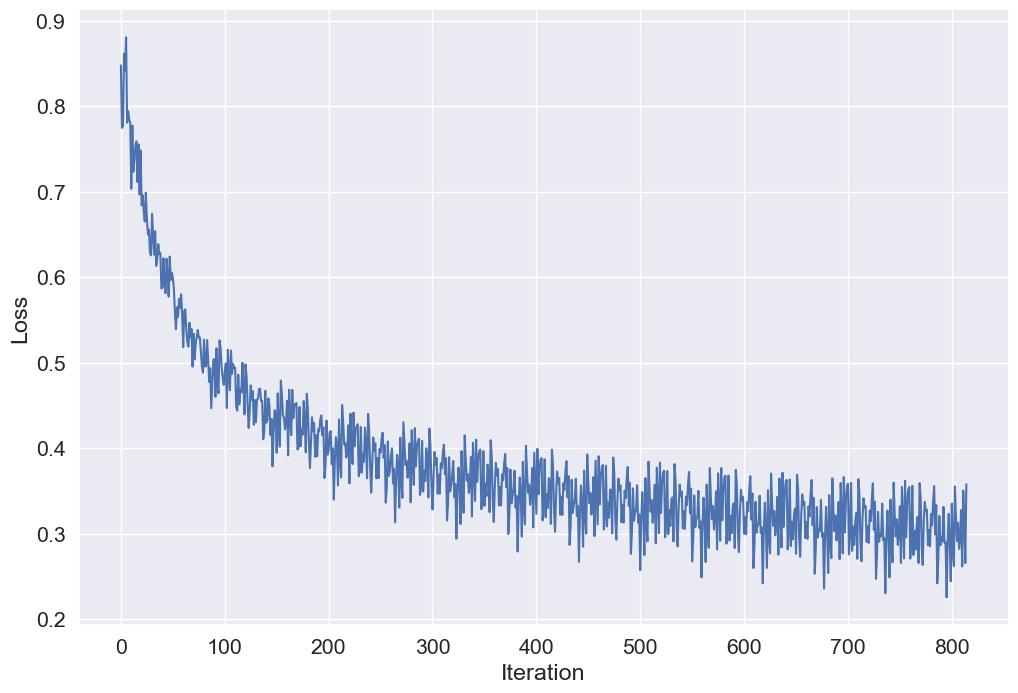

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

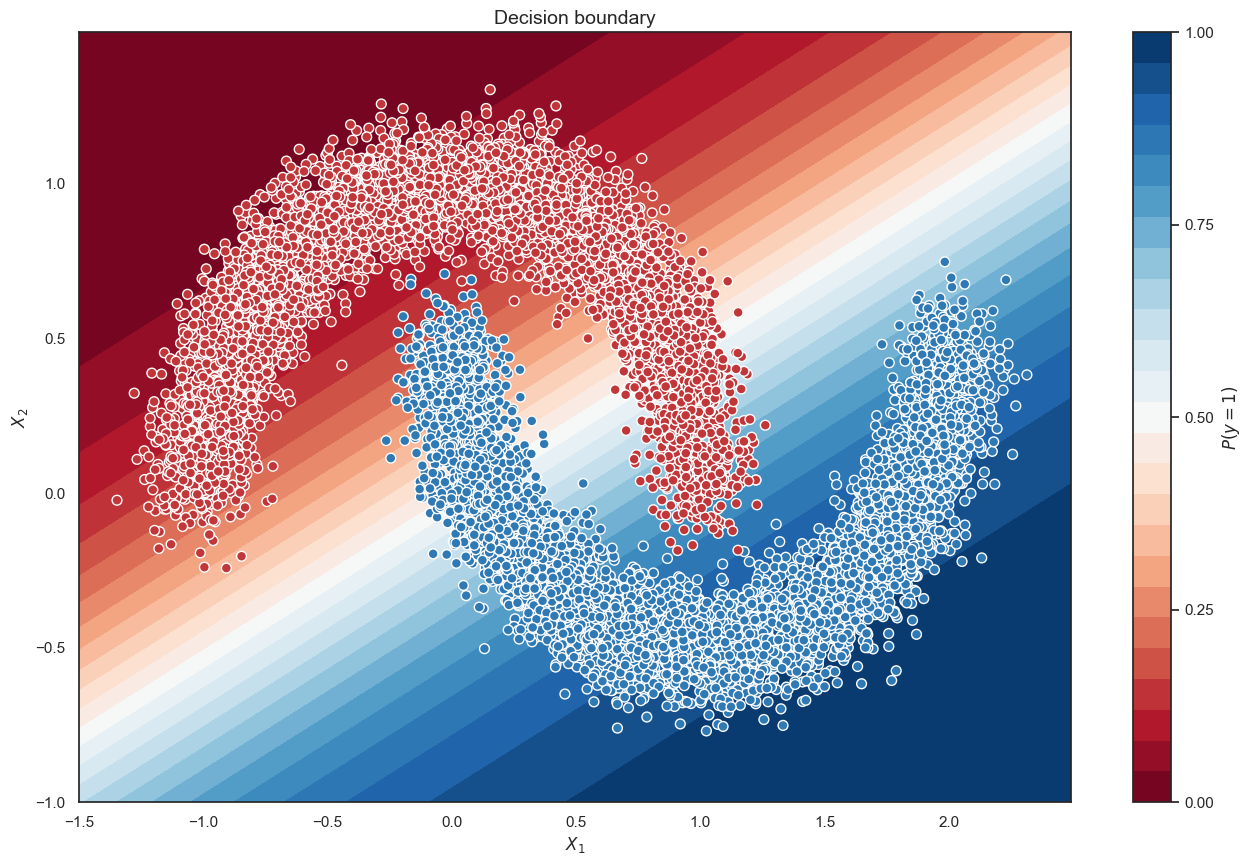

In [28]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [29]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:

        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long) #YOUR CODE. Compute predictions

        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [30]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
pred =  predict(val_dataloader, linear_regression)
print(accuracy_score(pred, y_val))
None

0.8596


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8596 удивительно

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [31]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

In [32]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True) # YOUR CODE GOES HERE

valid_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [33]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [34]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),

    #YOUR CODE. Add layers to your sequential class
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10)
)

In [35]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [37]:
# example
a = np.array([0, 1, 1])
b = np.array( [0, 1, 0])
res = a==b
print(res.sum())

2


### Задание. Дополните цикл обучения.

In [38]:
# НЕ ЗАПУСКАТЬ ЛИШНИЙ РАЗ
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        all_pred = 0

        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)

            epoch_correct += (y_batch == preds).sum() # YOUR CODE
            epoch_all += dataloader.batch_size        # YOUR CODE

            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9065999984741211
Loader: valid. Accuracy: 0.9334999918937683
Epoch: 2
Loader: train. Accuracy: 0.9458000063896179
Loader: valid. Accuracy: 0.9542999863624573
Epoch: 3
Loader: train. Accuracy: 0.9556666612625122
Loader: valid. Accuracy: 0.9510999917984009
Epoch: 4
Loader: train. Accuracy: 0.9600333571434021
Loader: valid. Accuracy: 0.9580000042915344
Epoch: 5
Loader: train. Accuracy: 0.9624999761581421
Loader: valid. Accuracy: 0.9617999792098999
Epoch: 6
Loader: train. Accuracy: 0.9651666879653931
Loader: valid. Accuracy: 0.9616000056266785
Epoch: 7
Loader: train. Accuracy: 0.9672333598136902
Loader: valid. Accuracy: 0.9574000239372253
Epoch: 8
Loader: train. Accuracy: 0.9684333205223083
Loader: valid. Accuracy: 0.9628000259399414
Epoch: 9
Loader: train. Accuracy: 0.9695000052452087
Loader: valid. Accuracy: 0.9671000242233276
Epoch: 10
Loader: train. Accuracy: 0.9703999757766724
Loader: valid. Accuracy: 0.9656999707221985


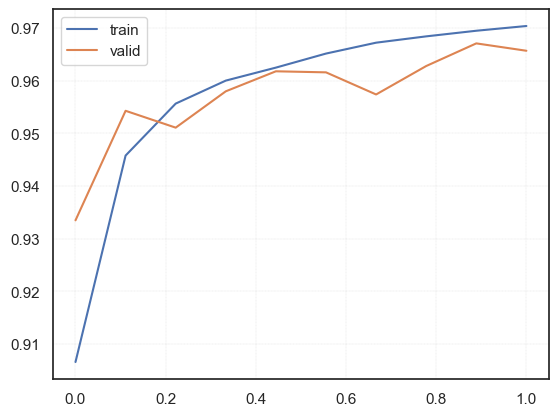

In [40]:
plt.plot(np.linspace(0,1,len(accuracy["train"])),
         accuracy["train"],
         np.linspace(0,1,len(accuracy["valid"])),
         accuracy["valid"])
plt.legend(["train","valid"])
plt.grid(linewidth=0.2, linestyle="--")
None

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [41]:
elu_accuracy = accuracy["valid"]

In [42]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def fit(model, loaders, criterion, optimizer, max_epochs = 10):
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)

                epoch_correct += (y_batch == preds).sum()
                epoch_all += dataloader.batch_size

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [43]:
def test_activation_function(activation):
    # create model
    model = nn.Sequential(
        nn.Flatten(),

        #YOUR CODE. Add layers to your sequential class
        nn.Linear(in_features=784, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=10)
    )

    return fit(model=model,
               criterion = nn.CrossEntropyLoss(),
               optimizer = torch.optim.Adam(model.parameters()),
               loaders=loaders,
               max_epochs=10)

- Хочу добавить, что не используя функции активации у нас практически остается не несколько, а один линейный слой, потому что несколько переменоженных матриц == одна большая матрица

In [44]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.8521000146865845
Loader: valid. Accuracy: 0.8827999830245972
Epoch: 2
Loader: train. Accuracy: 0.8813499808311462
Loader: valid. Accuracy: 0.8956000208854675
Epoch: 3
Loader: train. Accuracy: 0.8901333212852478
Loader: valid. Accuracy: 0.8902000188827515
Epoch: 4
Loader: train. Accuracy: 0.8925666809082031
Loader: valid. Accuracy: 0.90420001745224
Epoch: 5
Loader: train. Accuracy: 0.8959000110626221
Loader: valid. Accuracy: 0.9057000279426575
Epoch: 6
Loader: train. Accuracy: 0.8986333608627319
Loader: valid. Accuracy: 0.9021000266075134
Epoch: 7
Loader: train. Accuracy: 0.9000999927520752
Loader: valid. Accuracy: 0.9067999720573425
Epoch: 8
Loader: train. Accuracy: 0.9003000259399414
Loader: valid. Accuracy: 0.9041000008583069
Epoch: 9
Loader: train. Accuracy: 0.9006166458129883
Loader: valid. Accuracy: 0.9110999703407288
Epoch: 10
Loader: train. Accuracy: 0.9023333191871643
Loader: valid. Accuracy: 0.8939999938011169


In [45]:
relu_accuracy = test_activation_function(nn.ReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.9030333161354065
Loader: valid. Accuracy: 0.9334999918937683
Epoch: 2
Loader: train. Accuracy: 0.9440000057220459
Loader: valid. Accuracy: 0.9456999897956848
Epoch: 3
Loader: train. Accuracy: 0.9533833265304565
Loader: valid. Accuracy: 0.9448000192642212
Epoch: 4
Loader: train. Accuracy: 0.9570666551589966
Loader: valid. Accuracy: 0.9398000240325928
Epoch: 5
Loader: train. Accuracy: 0.9602333307266235
Loader: valid. Accuracy: 0.9592000246047974
Epoch: 6
Loader: train. Accuracy: 0.9617999792098999
Loader: valid. Accuracy: 0.9537000060081482
Epoch: 7
Loader: train. Accuracy: 0.9636666774749756
Loader: valid. Accuracy: 0.960099995136261
Epoch: 8
Loader: train. Accuracy: 0.9662166833877563
Loader: valid. Accuracy: 0.9638000130653381
Epoch: 9
Loader: train. Accuracy: 0.9656166434288025
Loader: valid. Accuracy: 0.9591000080108643
Epoch: 10
Loader: train. Accuracy: 0.9671333432197571
Loader: valid. Accuracy: 0.9531999826431274


In [46]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.9044166803359985
Loader: valid. Accuracy: 0.9455999732017517
Epoch: 2
Loader: train. Accuracy: 0.9429000020027161
Loader: valid. Accuracy: 0.9535999894142151
Epoch: 3
Loader: train. Accuracy: 0.9524499773979187
Loader: valid. Accuracy: 0.9523000121116638
Epoch: 4
Loader: train. Accuracy: 0.9569666385650635
Loader: valid. Accuracy: 0.9643999934196472
Epoch: 5
Loader: train. Accuracy: 0.9603999853134155
Loader: valid. Accuracy: 0.9624000191688538
Epoch: 6
Loader: train. Accuracy: 0.9618499875068665
Loader: valid. Accuracy: 0.9610000252723694
Epoch: 7
Loader: train. Accuracy: 0.9633499979972839
Loader: valid. Accuracy: 0.9628000259399414
Epoch: 8
Loader: train. Accuracy: 0.965399980545044
Loader: valid. Accuracy: 0.9549999833106995
Epoch: 9
Loader: train. Accuracy: 0.9654666781425476
Loader: valid. Accuracy: 0.9649999737739563
Epoch: 10
Loader: train. Accuracy: 0.9657166600227356
Loader: valid. Accuracy: 0.9617000222206116


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

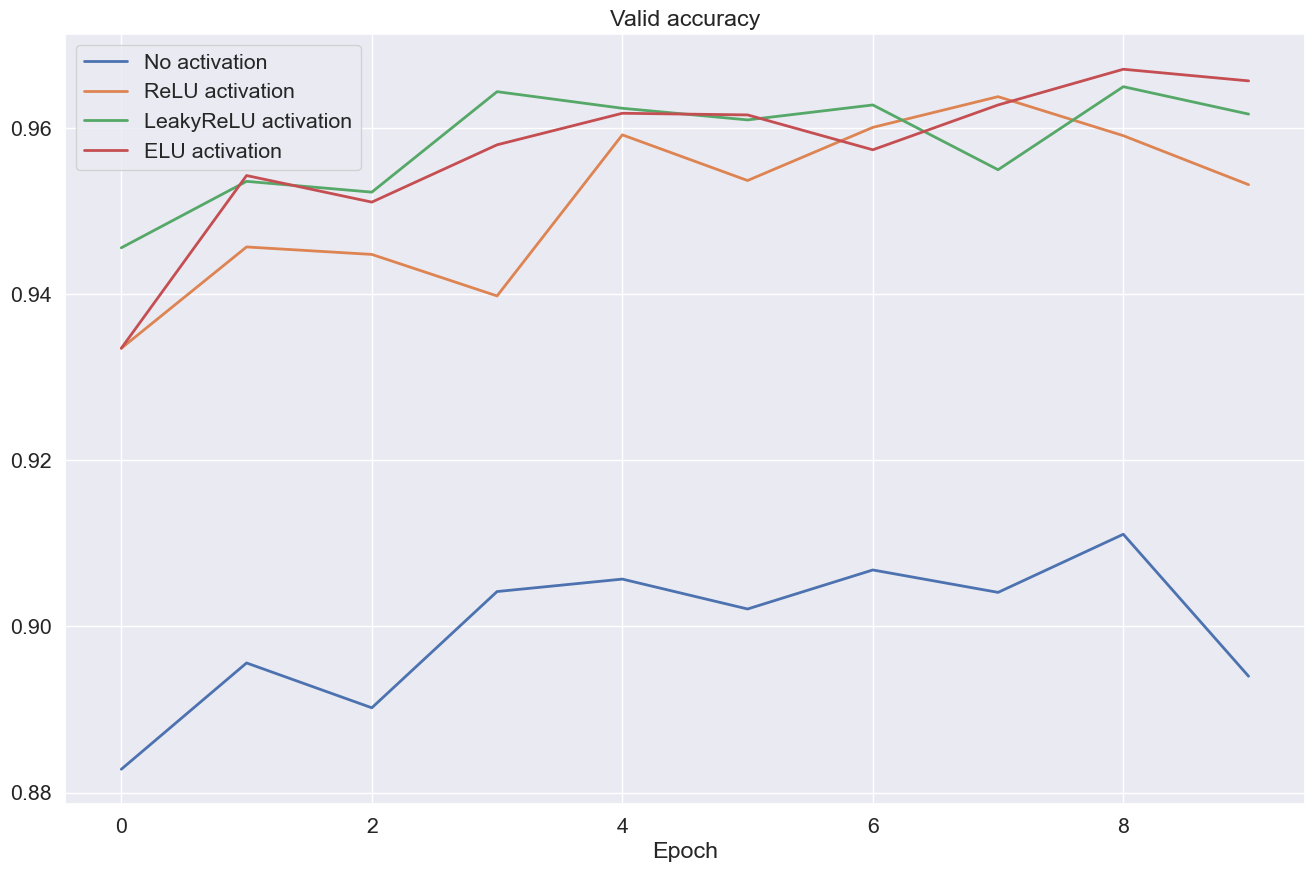

In [49]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

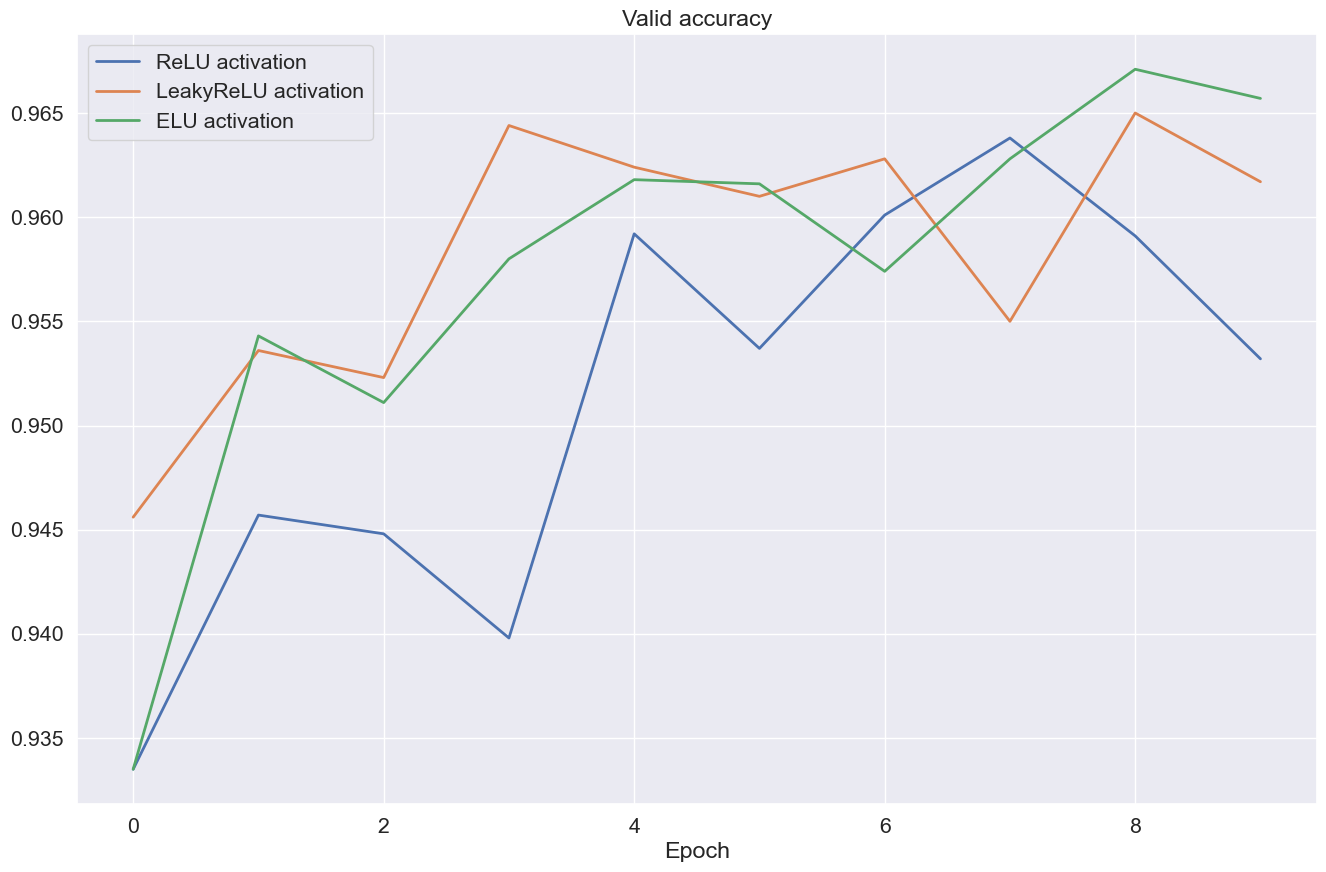

In [50]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** RelU {max(0,x)}

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [51]:
# !wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg
# сам скачаю =(

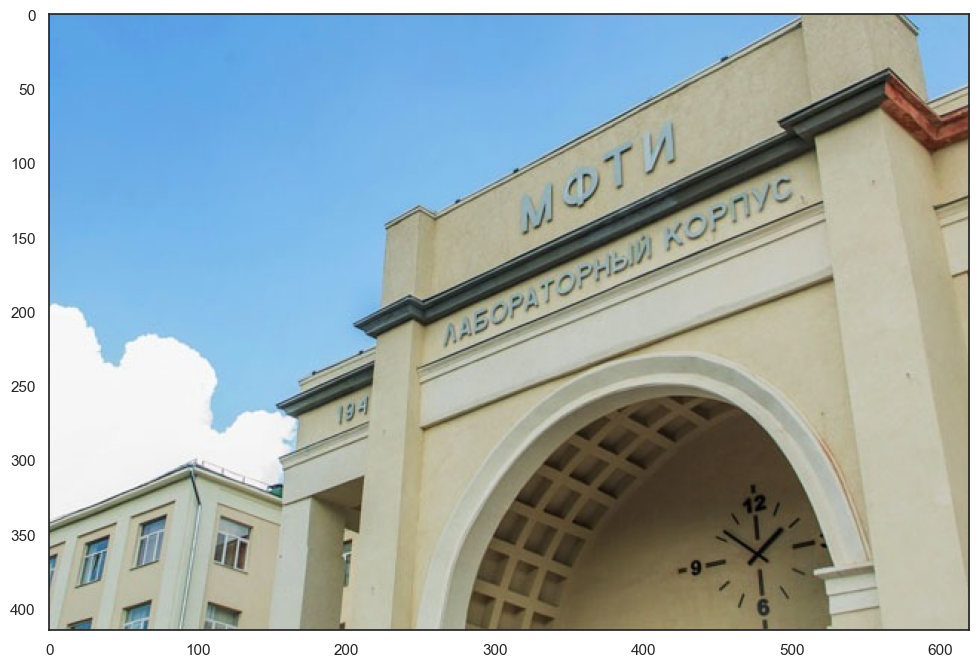

In [52]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [53]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [-6, -3, 0],
    [-3, 0, 3],
    [0, 3, 6]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


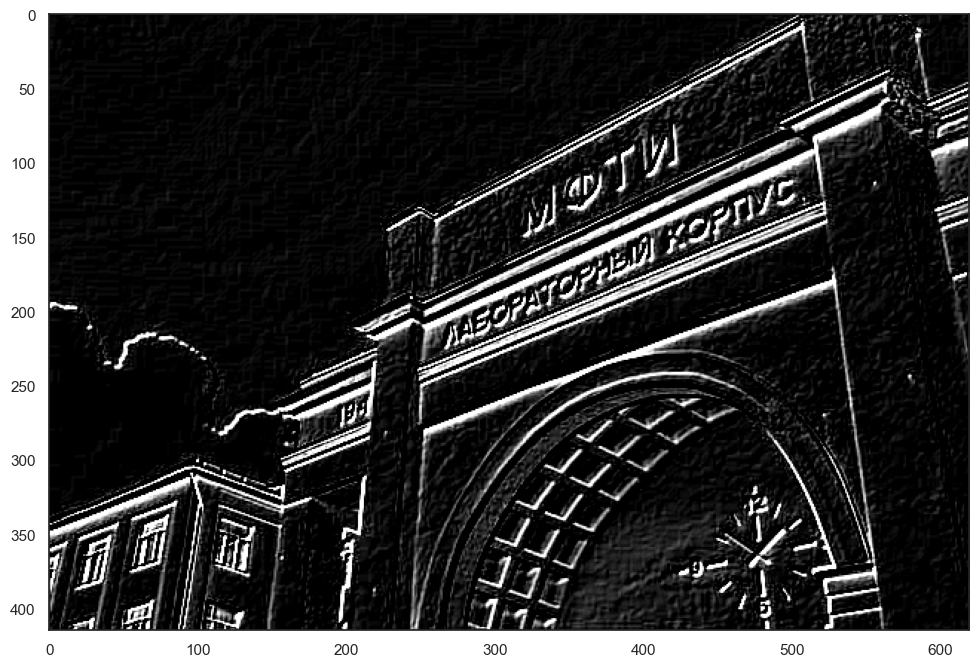

In [54]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е (размытие по Гауссу)
2) Увеличение резкости - Д (Лапласиан)
3) Тождественное преобразование - А
4) Выделение вертикальных границ - В
5) Выделение горизонтальных границ - Б
6) Выделение границ - Г

**Ответ:** Е Д А В Б Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [55]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)  # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 400,out_features=120)
        self.fc2 = nn.Linear(in_features= 120,out_features=84)
        self.fc3 = nn.Linear(in_features= 84,out_features=10)

    def forward(self, x):

        # [batch_size, 1, 28, 28]
        x = nn.functional.relu(self.conv1(x))

        # [batch_size, 6, 26, 26]
        x = self.pool1(x)

        # [batch_size, 6, 13, 13]
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)

        # [batch_size, 6, 5, 5]
        x = self.flatten(x)
        # [1600]
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [56]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [57]:
# функция написанная выше
lenet_accuracy = fit(model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    loaders=loaders)

Epoch: 1
Loader: train. Accuracy: 0.956333339214325
Loader: valid. Accuracy: 0.9832000136375427
Epoch: 2
Loader: train. Accuracy: 0.9833499789237976
Loader: valid. Accuracy: 0.9818999767303467
Epoch: 3
Loader: train. Accuracy: 0.9868999719619751
Loader: valid. Accuracy: 0.986299991607666
Epoch: 4
Loader: train. Accuracy: 0.9887333512306213
Loader: valid. Accuracy: 0.9882000088691711
Epoch: 5
Loader: train. Accuracy: 0.9904500246047974
Loader: valid. Accuracy: 0.9883999824523926
Epoch: 6
Loader: train. Accuracy: 0.9921833276748657
Loader: valid. Accuracy: 0.9889000058174133
Epoch: 7
Loader: train. Accuracy: 0.9928500056266785
Loader: valid. Accuracy: 0.9857000112533569
Epoch: 8
Loader: train. Accuracy: 0.9934666752815247
Loader: valid. Accuracy: 0.9854999780654907
Epoch: 9
Loader: train. Accuracy: 0.9934166669845581
Loader: valid. Accuracy: 0.986299991607666
Epoch: 10
Loader: train. Accuracy: 0.994350016117096
Loader: valid. Accuracy: 0.9858999848365784


Сравним с предыдущем пунктом

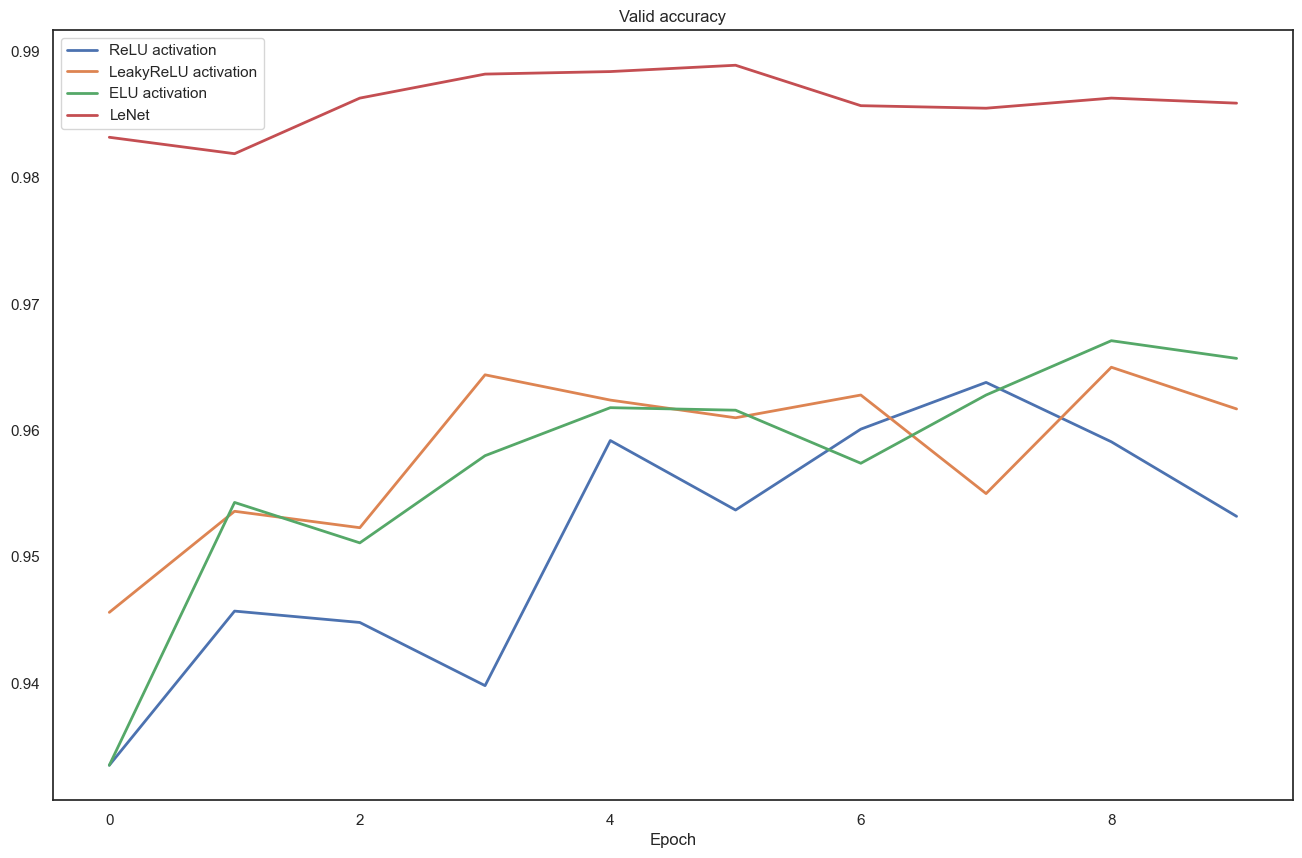

In [62]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99